Installing the libraries

In [1]:
!pip install -r requirements.txt

ERROR: Could not find a version that satisfies the requirement tensorflow==2.5.0 (from versions: 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow==2.5.0

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: C:\Users\saf\OneDrive\Desktop\CNN_LSTM\venv\Scripts\python.exe -m pip install --upgrade pip


Import the libraries

In [1]:
import cv2
import os
import math
import random
import numpy as np
import datetime as dt 
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping

Random Seeds for consistent results on every execution

In [2]:
seed_constant = 27 
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

For visualization of dataset so that you can check if the datasets are on the correct classes (Does not serve any other purpose)

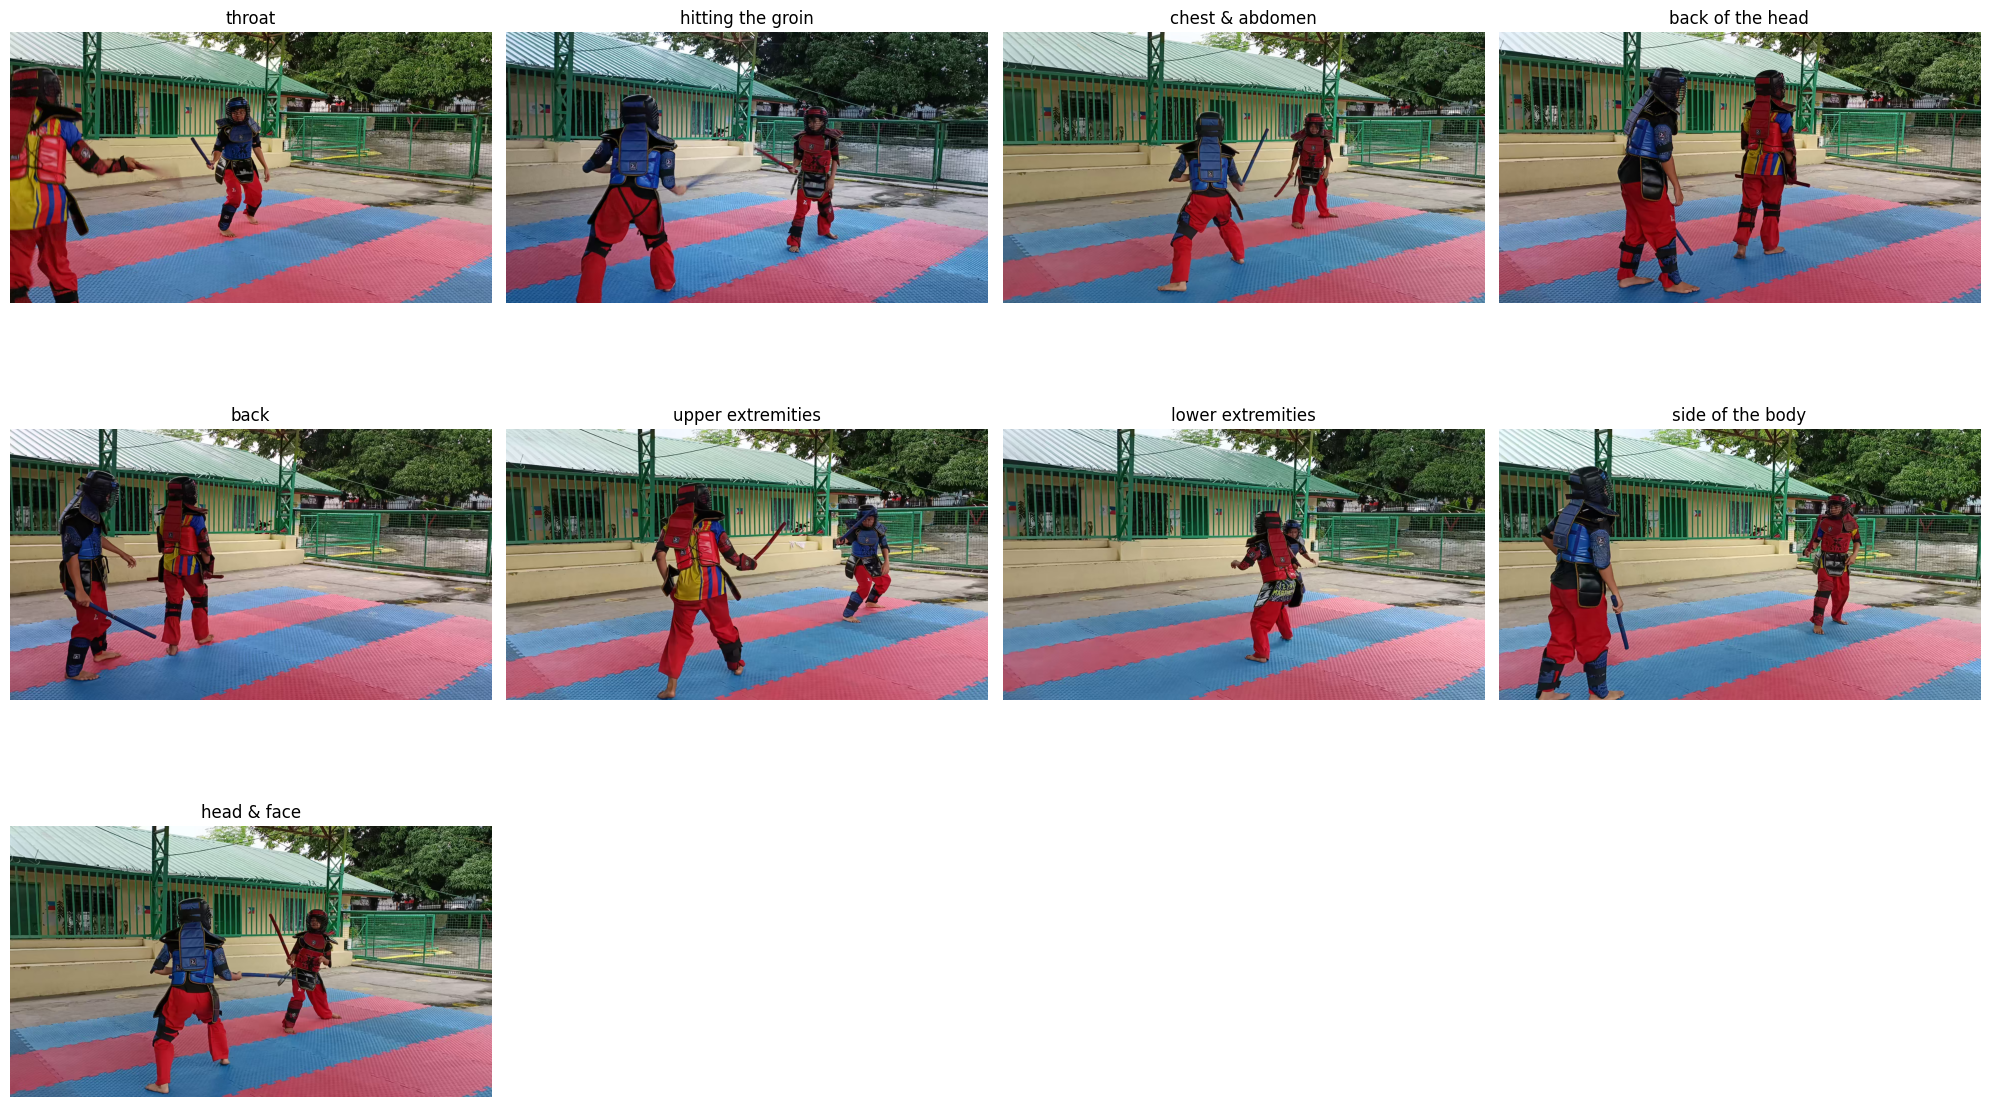

In [3]:

plt.figure(figsize=(20, 20))

all_classes_name = os.listdir('dataset')

random_range = random.sample(range(len(all_classes_name)), min(20, len(all_classes_name)))

for counter, random_index in enumerate(random_range, 1):
    selected_class_name = all_classes_name[random_index]
    video_files_names_list = os.listdir(f'dataset/{selected_class_name}')
    selected_video_file_name = random.choice(video_files_names_list)

    video_reader = cv2.VideoCapture(f"dataset/{selected_class_name}/{selected_video_file_name}")
    success, bgr_frame = video_reader.read()
    video_reader.release()

    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    plt.subplot(5, 4, counter)
    plt.title(selected_class_name)
    plt.imshow(rgb_frame)
    plt.axis("off")

plt.tight_layout()
plt.show()


Preprocessing the dataset


-Image Height & Weight: so that the frames will be fixed and consistent
-Sequence Length: the number of frames of for each video that we will extract
-Dataset Directory: set the directory of the datasets (it will be useful)
-Class List: define the dataset classes

In [4]:
IMAGE_HEIGHT, IMAGE_WIDTH = 224, 224
SEQUENCE_LENGTH = 20
DATASET_DIR = 'dataset'
CLASS_LIST = sorted([
    folder_name for folder_name in os.listdir(DATASET_DIR)
    if os.path.isdir(os.path.join(DATASET_DIR, folder_name))
])

print("Number of classes:", len(CLASS_LIST))
print("Class list:", CLASS_LIST)


Number of classes: 9
Class list: ['back', 'back of the head', 'chest & abdomen', 'head & face', 'hitting the groin', 'lower extremities', 'side of the body', 'throat', 'upper extremities']


In [12]:
def frames_extraction(video_path):
    frame_list = []

    video_reader = cv2.VideoCapture(video_path)

    vide_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = max(int(vide_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame/255

        frame_list.append(normalized_frame)

    video_reader.release()

    return frame_list

In [13]:
def create_dataset():
    features = []
    labels = []
    video_file_paths = []

    for class_index, class_name in enumerate(CLASS_LIST):
        print(f"Extracting Data of the Class {class_name}")
        
        file_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        file_list = file_list[:50] 

        for file_name in file_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            
            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_file_paths.append(video_file_path)
    
    features = np.array(features)
    labels = np.array(labels)

    return features, labels, video_file_paths


In [14]:
features, labels, video_file_paths = create_dataset()

Extracting Data of the Class back
Extracting Data of the Class back of the head
Extracting Data of the Class chest & abdomen
Extracting Data of the Class head & face
Extracting Data of the Class hitting the groin
Extracting Data of the Class lower extremities
Extracting Data of the Class side of the body
Extracting Data of the Class throat
Extracting Data of the Class upper extremities


In [15]:
one_hot_encoded_labels = to_categorical(labels)

In [16]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size=0.30, shuffle=True, random_state=seed_constant)

Constructing the model

In [ ]:
def create_convlstm_model():
    model = Sequential()

    model.add(ConvLSTM2D(
        filters=4,
        kernel_size=(3, 3),
        activation='tanh',
        data_format='channels_last',
        recurrent_dropout=0.2,
        return_sequences=True,
        input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)
    ))

    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(
        filters=8,
        kernel_size=(3, 3),
        activation='tanh',
        data_format='channels_last',
        recurrent_dropout=0.2,
        return_sequences=True
    ))

    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(
        filters=20,
        kernel_size=(3, 3),
        activation='tanh',
        data_format='channels_last',
        recurrent_dropout=0.2,
        return_sequences=True
    ))

    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(
        filters=24,
        kernel_size=(3, 3),
        activation='tanh',
        data_format='channels_last',
        recurrent_dropout=0.2,
        return_sequences=True
    ))

    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))

    model.add(Flatten())

    model.add(Dense(len(CLASS_LIST), activation='softmax'))

    model.summary()

    return model


In [12]:
convlstm_model = create_convlstm_model()

d:\CNN_LSTM\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 20, 222, 222,   │         1,024 │
│                                 │ 4)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 20, 111, 111,   │             0 │
│                                 │ 4)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 20, 111, 111,   │             0 │
│ (TimeDistributed)               │ 4)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 20, 109, 109,   │         3,488 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 20, 55, 55, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 55, 55, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 20, 53, 53, 14) │        11,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 20, 27, 27, 14) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 27, 27, 14) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 20, 25, 25, 16) │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 20, 13, 13, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 54080)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │       486,729 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 519,729 (1.98 MB)

 Trainable params: 519,729 (1.98 MB)

 Non-trainable params: 0 (0.00 B)

Train the model

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

convlstm_model.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

history = convlstm_model.fit(
    x=features_train, 
    y=labels_train, 
    epochs=50,
    batch_size=32,
    validation_split=0.15,
    callbacks=[early_stopping_callback],
    shuffle=True
)

Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.1448 - loss: 2.2716 - val_accuracy: 0.0526 - val_loss: 2.1830
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.2120 - loss: 2.1466 - val_accuracy: 0.8000 - val_loss: 0.6973
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.7634 - loss: 0.7026 - val_accuracy: 0.9684 - val_loss: 0.1584
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9303 - loss: 0.1661 - val_accuracy: 0.9158 - val_loss: 0.2370
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.9686 - loss: 0.1085 - val_accuracy: 0.9053 - val_loss: 0.3014
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.9933 - loss: 0.0535 - val_accuracy: 0.9158 - val_loss: 0.3469
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9862 - loss: 0.0351 - val_accuracy: 0.9158 - val_loss: 0.2174
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9902 - loss: 0.0583 - val_accuracy: 0.8842 - val_los

Evaluating the result base on the test datasets

In [14]:
model_evaluate_history = convlstm_model.evaluate(features_test, labels_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.9594 - loss: 0.1705


Saving the Model

In [15]:
convlstm_model.save('output/models/convlstm_v3.h5')

Plotting the Accuracy Results

In [16]:
def plot_metric(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


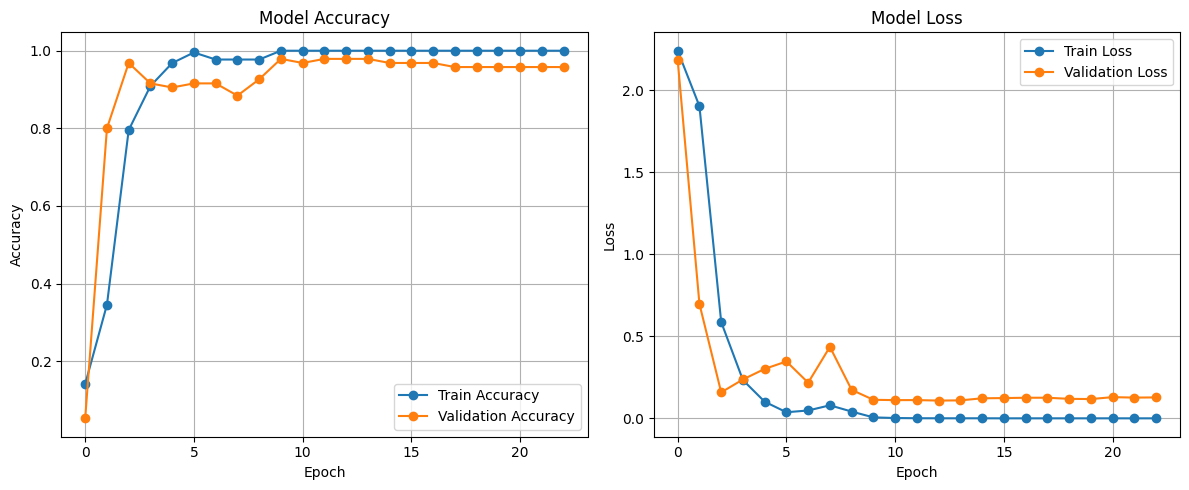

In [17]:
plot_metric(history)

Sample test code to verify the accuracy of the result outside the test datasets

In [1]:
from tensorflow.keras.models import load_model

convlstm_model = load_model('output/models/convlstm_v3.h5')

def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = video_reader.get(cv2.CAP_PROP_FPS)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  
    video_writer = cv2.VideoWriter(
        output_file_path, fourcc, fps, (original_video_width, original_video_height)
    )

    frames_queue = deque(maxlen=SEQUENCE_LENGTH)
    predicted_class = ''

    while video_reader.isOpened():
        ok, frame = video_reader.read()
        if not ok:
            break

        resized_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
        normalized_frame = resized_frame / 255.0

        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:
            input_frames = np.expand_dims(np.array(frames_queue), axis=0)
            predictions = convlstm_model.predict(input_frames, verbose=0)
            predicted_class = CLASS_LIST[np.argmax(predictions)]

        cv2.putText(frame, f"Prediction: {predicted_class}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        video_writer.write(frame)

    video_reader.release()
    video_writer.release()
    print(f"Prediction video saved to {output_file_path}")

In [ ]:
predict_on_video('dataset/VID20250719143147.mp4', 'upper.mp4', SEQUENCE_LENGTH)

Prediction video saved to upper.mp4
